<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ufidon/ml/blob/main/mod6/seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ufidon/ml/blob/main/mod6/seq.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>
<br>

Processing Sequences Using RNNs and CNNs
---
_homl3 ch15_


- `recurrent neural networks(RNNs)` can predict the future up to a point
  - can analyze time series data
  - can forecast the future with learned past patterns in the data
  - assuming that past patterns still hold in the future
  - can work on `sequences of arbitrary lengths`, 
    - rather than on fixed-sized inputs
  - has vast applications
    - natural language processing (NLP) such as automatic translation, speech-to-text, etc.
    - prediction of weather, stock, user activities on a website, etc.
  - trained with backprop through time
  - faces two main difficulties
    - Unstable gradients
      - can be alleviated by various techniques such as recurrent dropout and recurrent layer normalization.
  - has a very limited short-term memory
    - can be extended using LSTM and GRU cells
- `regular dense networks` can tackle `small` sequences
- `CNNs` such as WaveNet can handle `very long` sequences such as audio samples or text

In [3]:
# Colab: Go to Runtime > Change runtime and select a GPU hardware
# Kaggle: Go to Settings > Accelerator and select GPU
# ⚠️ 
import sys, math

if "google.colab" in sys.modules:
  %pip install -q -U statsmodels

from functools import partial
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sklearn as skl, sklearn.datasets as skds, tensorflow as tf
from sklearn.datasets import load_sample_images

Recurrent Neurons (RNs) and Layers
---
- A RNN  looks like a feedforward neural network
  - except it also has `connections pointing backward`
- the `simplest possible RNN` is composed of `one neuron` 
  - (p1①) receiving inputs, producing an output, and sending that output back to itself
    - ${ \hat{y}_{(t)} = r(\mathbf{x}_{(t)}, \hat{y}_{(t-1)}) }$ with ${ \hat{y}_{(0)}=0 }$
  - (p1②) `unrolling the network through time` represents this RN against the time axis
    - it’s the same RN represented once per time step
- a layer of RNs (p2①)
  - (p2②) receives both the input vector ${ \mathbf{x}_{(t)} }$ and the output vector from the previous time step ${\mathbf{\hat{y}}_{(t-1)} }$ at each time step t
- Each recurrent neuron has two sets of weights:
  - ${ \mathbf{w_x} }$ for the inputs ${ \mathbf{x}_{(t)} }$ 
  - ${ \mathbf{w_{\hat{y}}} }$ for the outputs of the previous time step ${ \hat{\mathbf{y}}_{(t-1)} }$
  - ∴ the whole layer of RNs has two weight matrixes: ${ \mathbf{W_x} }$ and ${ \mathbf{W_{\hat{y}}} }$
- the equation of the output of a recurrent layer with $n_n$ neurons and $n_f$ input features
  - for a single instance 
    - ${ \mathbf{\hat{y}}_{(t)}=ϕ\left( \mathbf{W_x}^T \mathbf{x}_{(t)} + \mathbf{W_{\hat{y}}}^T \mathbf{\hat{y}}_{(t-1)} + \mathbf{b} \right) }$
  - for ${n_b}$ instances in a pass (mini-batch) 
    - 🅰 ${ \mathbf{\hat{Y}}_{(t)}=ϕ\left( \mathbf{X}_{(t)}\mathbf{W_x} + \mathbf{\hat{Y}}_{(t-1)}\mathbf{W_{\hat{y}}}  + \mathbf{b} \right) }$
    - = ${ ϕ\left( [\mathbf{X}_{(t)}\;\mathbf{\hat{Y}}_{(t-1)}]\mathbf{W}  + \mathbf{b} \right) }$ with ${ \mathbf{W} = \begin{bmatrix}\mathbf{W_x}\\ \mathbf{W_{\hat{y}}}\end{bmatrix} }$
    - ${ \mathbf{\hat{Y}}_{(t)} }$ is an ${ n_b×n_n }$ matrix containing the layer’s outputs at time step t for all $n_b$ instances
    - ${ \mathbf{X}_{(t)} }$ is an ${ n_b×n_f }$ matrix containing the inputs for all $n_b$ instances
    - ${ \mathbf{W_x} }$ is an ${ n_f×n_n }$ matrix containing the connection weights for the inputs of the current time step
    - ${ \mathbf{W_{\hat{y}}} }$ is an ${ n_n×n_n }$ matrix containing the connection weights for the outputs of the previous time step
    - ${ \mathbf{b} }$ is a vector of size ${ n_n }$ containing each neuron’s bias term
  - 🅰 is a `recurrent equation` so ${ \mathbf{\hat{Y}}_{(t)} }$ is a function of ${ \mathbf{X_{(0)}},\mathbf{X_{(1)}},\mathbf{X_{(2)}},⋯, \mathbf{X_{(t)}} }$

Memory Cells
---
- A part of a neural network that preserves some state across time steps is called a `memory cell (or simply a cell)`
- A single recurrent neuron or a layer of recurrent neurons is a very basic cell
  - capable of learning only `short patterns` depending on the task
    - typically about 10 steps long
- (p3) A cell’s state ${ \mathbf{h}_{(t)} }$ and output ${ \mathbf{\hat{y}}_{(t)} }$ at time step t
  - ${ \mathbf{h}_{(t)} = f( \mathbf{x}_{(t)}, \mathbf{h}_{(t-1)} ) }$
  - ${ \mathbf{\hat{y}}_{(t)} = g( \mathbf{x}_{(t)}, \mathbf{h}_{(t-1)} ) }$
  - f may equal g depending on the task

Popular RNN structures
---
- (p4①) A `sequence-to-sequence` RNN takes a sequence of inputs and produces a sequence of outputs
  - ex. predict the temperatures from `n-1 days ago to tomorrow` based on the temperatures of `last n days`
- (p4②) A `a sequence-to-vector` RNN takes a sequence of inputs and ignores all outputs except for the last one
  - ex. predict a sentiment score from a sequence of words corresponding to a product review
- (p4③) A `vector-to-sequence` RNN intakes the same input vector at each time step outputs a sequence
  - ex. predict a caption for an image or the output of a CNN
- (p4④) A `encoder-decoder` RNN is a `sequence-to-vector` RNN called an `encoder` followed by a vector-to-sequence RNN called a `decoder`
  - ex. translates a sentence from one language to another
  - the encoder converts this sentence into a single vector representation
  - then the decoder decodes this vector into a sentence in another language
  - works much better than translating on the fly with a single `sequence-to-sequence` RNN
- (p5) A `deep RNN` stacks multiple layers of cells

Training RNNs
---
- by `backpropagation through time (BPTT)` strategy (p6)
  - `unroll` the RNN through time and then use regular `backpropagation`
  - apply `forward pass` through the unrolled network 
    - represented by the dashed arrows
  - evaluate the output using a `loss function` ${ℒ\left( \mathbf{Y}_{(0)},\mathbf{Y}_{(1)},⋯,\mathbf{Y}_{(T)}; \mathbf{\hat{Y}}_{(0)},\mathbf{\hat{Y}}_{(1)},⋯,\mathbf{\hat{Y}}_{(T)} \right) }$
    - this loss function may ignore some outputs based on the RNN types above
  - `propagate backward` the gradients of that loss function through the unrolled network 
    - represented by the solid arrows
  - perform a `gradient descent` step to update the parameters 
    - once the backward phase is complete and all the gradients have been computed
- in this example (p5),
  - the outputs ${ \mathbf{\hat{Y}}_{(0)},\mathbf{\hat{Y}}_{(1)} }$ are not used to compute the loss
    - the gradients do not flow backward through them
    - they only flow through ${ \mathbf{\hat{Y}}_{(2)},\mathbf{\hat{Y}}_{(3)},\mathbf{\hat{Y}}_{(4)} }$
  -  the same parameters ${ \mathbf{W} }$ and ${ \mathbf{b} }$ are used at each time step, their gradients will be `tweaked multiple times` during backprop


In [4]:
# 1. Forecasting a Time Series
#  forecast the number of passengers that will 
#     ride on bus and rail the next day in Chicago
#     based on the daily ridership data since 2001
# 1) load and clean up the data
# if you run the code on Colab, download 
# [cta.csv](https://raw.githubusercontent.com/ufidon/ml/main/datasets/cta.csv)
# and upload to Colab, adjust the path accordingly
# for the most recent data, download it from
# https://data.cityofchicago.org/Transportation/CTA-Ridership-Daily-Boarding-Totals/6iiy-9s97/about_data

if "google.colab" in sys.modules:
  !wget "https://raw.githubusercontent.com/ufidon/ml/main/datasets/cta.csv"
  df = pd.read_csv("./cta.csv", parse_dates=["service_date"])
else:
  df = pd.read_csv("../datasets/cta.csv", parse_dates=["service_date"])
  
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [5]:
# day_type: W for Weekdays, A for Saturdays, and U for Sundays or holidays
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


- This is a `time series`: 
  - data with values at different time steps usually at regular intervals
    - a `multivariate time series` has multiple values per time step
      - ex. (bus, rail) two or more columns vs. date
    - a `univariate time series` has a single value per time step
       - ex. (bus) one column vs. date
- Typical tasks on time series:
  - forecast future values
  - imputation (filling in missing past values)
  - classification
  - anomalydetection, etc.

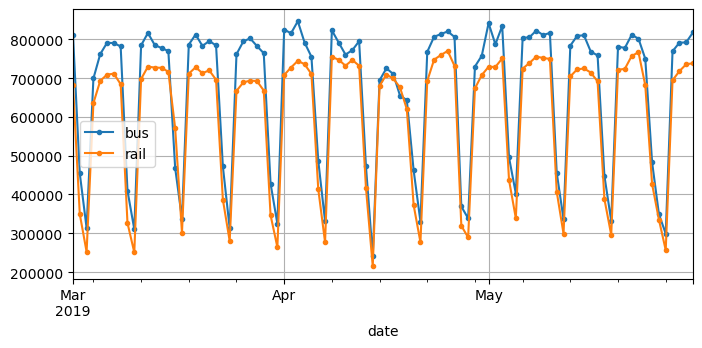

In [6]:
# 2)  plot the `bus and rail ridership` figures 
#     over a few months in 2019
fig1, ax1 = plt.subplots(figsize=(8, 3.5))
df["2019-03":"2019-05"].plot(ax=ax1, grid=True, marker=".");

- In the figure above, a similar pattern is clearly repeated every week. 
  - This is called a `weekly seasonality`
- `naive forecasting` simply copies a past season to forecast a future season
  - offers a great baseline

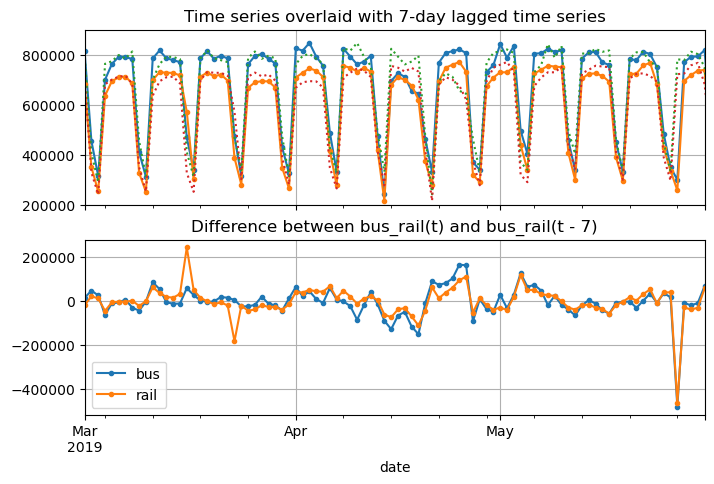

In [7]:
# 3) visualize naive forecast
# by shifting one season forward and plot the difference 
# between the old one and the shifted one - called `differencing`

diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig2, ax2 = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=ax2[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=ax2[0], legend=False, grid=True, linestyle=":")
ax2[0].set_ylim([200_000, 900_000])
ax2[0].set_title("Time series overlaid with 7-day lagged time series")

diff_7.plot(ax=ax2[1], grid=True, marker=".");  # 7-day difference time series
ax2[1].set_title("Difference between bus_rail(t) and bus_rail(t - 7)");

In [8]:
# there was a long weekend (the Memorial Day) at the end of May
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

- In the figure above, the lagged time series closely track the actual time series
  - most of the differences are fairly small
  - except at the end of May since there was a long weekend
- A time series is `autocorrelated` when it is `correlated with` a lagged version of itself
- The prediction performance can be measured with
  - `Mean absolute error (MAE)`, also called `mean absolute deviation (MAD)`
  - or `Mean absolute percentage error (MAPE)`

In [9]:
# 4).  measure the MAE over the three-month period
# hard to tell good or bad for each one
# but MAE(raid) is smaller (better) than MAE(bus)
naive_mae = diff_7.abs().mean()
naive_mae

bus     43915.608696
rail    42143.271739
dtype: float64

In [10]:
# 5) measure the MAPE
# now MAPE(bus) is smaller (better) than MAPE(rail)
# which one is better on earth? bus!
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

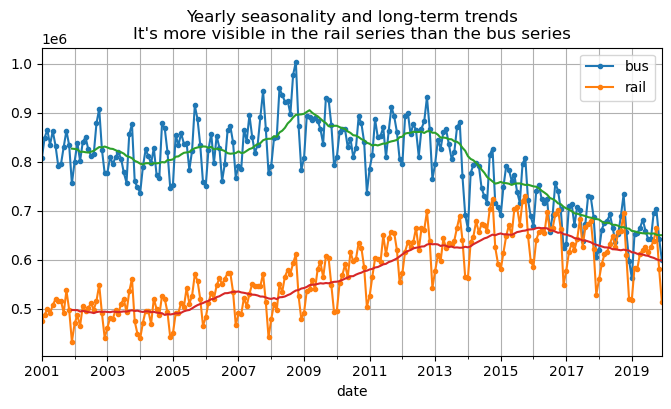

In [11]:
# 6) other seasonality
# It doesn’t appear to be any significant monthly seasonality
# any yearly seasonality?
# plot a 12-month rolling average for each series to 
# visualize long-term trends 

period = slice("2001", "2019")
if "google.colab" in sys.modules:
  df_monthly = df[["bus", "rail"]].resample('M').mean()
else:
  df_monthly = df[["bus", "rail"]].resample('ME').mean()  # compute the mean for each month
  
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig3, ax3 = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax3, marker=".")
rolling_average_12_months.plot(ax=ax3, grid=True, legend=False)
ax3.grid(which='minor')
ax3.set_title("Yearly seasonality and long-term trends\n"
              "It's more visible in the rail series than the bus series");

- based on the `rolling (moving) average`
  - daily bus ridership dropped by about 2,500 in October 2017
  - about 570 fewer passengers each week
- so it makes sense to predict the week at the end of October 2017 with the value from previous week minus 570

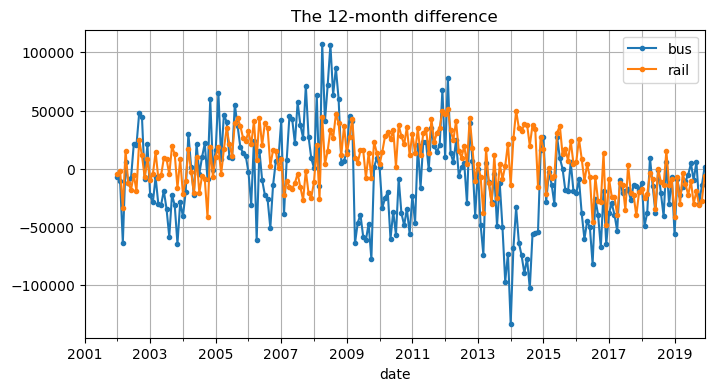

In [12]:
# 7) plot the 12-month difference
#  
fig4, ax4 = plt.subplots(figsize=(8, 4))
df_monthly.diff(12)[period].plot(ax=ax4, grid=True, marker=".")
ax4.grid(which='minor')
ax4.set_title("The 12-month difference");

- `differencing` is a common technique used to `remove trend and seasonality` from series
  - ex. the `linear downward trend` present in the time series from 2016 to 2019 
  - became a `roughly constant negative value` in the differenced time series
- it’s easier to study a `stationary` time series
  - whose `statistical properties remain constant`
  - without any seasonality or trends over time
- Once accurate forecasts on the differenced time series are made,
  - it is easy to turn the forecasts on the differencedtime series 
  - into forecasts for the actual time series by just adding back the past values
- the long-term patterns often matter much less than the short-term ones
  - but can be improved slightly by taking `long-term patterns` into account

The ARMA Model Family
---
- short for the `autoregressive moving average (ARMA)` model
- computes its forecasts using a `simple weighted sum` of lagged values 
  - then corrects these forecasts by `adding a moving average`
- as the forecasting equation
  - ${\displaystyle \hat{y}_{(t)} = \sum_{i=1}^p \alpha_i y_{(t-i)} + \sum_{i=1}^q \theta_i \epsilon_{(t-i)} }$
  - with ${ \epsilon_{(t)} = y_{(t)} - \hat{y}_{(t)} }$
  - ${ \hat{y}_{(t)} }$ is the model’s forecast for time step t
  - ${ y_{(t)} }$ the time series’ value at time step t
  - ${ \sum_{i=1}^p \alpha_i y_{(t-i)} }$ is the `weighted sum of the past p values` of the time series
    - or the `autoregressive component` of the model that performs regression based on past values using the learned weights `αᵢ`
    - `p` is a hyperparameter that determines how far back into the past the model should look
  - ${ \sum_{i=1}^q \theta_i \epsilon_{(t-i)} }$ is `the weighted sum over the past q forecast errors ε₍ₜ₎` using the learned weights `θᵢ`
    - or the `moving average component` of the model
    - `q` is a hyperparameter
- assumes that the time series is `stationary`
  - if not then `differencing` the series first
- `differencing` over a single time step will produce an `approximation of the derivative` of the time series
  - i.e. give the slope of the series at each time step
  - eliminate any `linear trend` by transforming it into a constant value
    - based on derivative: `(cx)' = c`
  - ex.  [3, 5, 7, 9, 11] → one-step differencing →  [2, 2, 2, 2]
- `two rounds of differencing` will eliminate `quadratic trends`
  - based on derivative: `(cx²)'' = 2c`
  - ex.  [1, 4, 9, 16, 25, 36] → one-step differencing → [3, 5, 7, 9, 11] 
    - → one-step differencing → [2, 2, 2, 2]
- `d consecutive rounds of differencing` computes an approximation of the `dᵗʰ order derivative` of the time series
  - eliminates `polynomial trends` up to degree d
  - based on derivative: ${ (cxᵈ)^{(d)} = d!c }$
  - This hyperparameter d is called `the order of integration`

Two popular models of ARMA
---
- the `autoregressive integrated moving average (ARIMA)` model
  - runs d rounds of differencing to make the time series more stationary
  - then applies a regular ARMA model for training
  - When making forecasts,
    - it uses this ARMA model and adds back the terms that were subtracted by differencing
- the `seasonal ARIMA (SARIMA)` model
  - models the time series in the same way as ARIMA
  - additionally models a seasonal component for a given frequency using the exact same ARIMA approach
  - has a total of 7 hyperparameters: 
    - the same p, d, and q hyperparameters as ARIMA
    - plus additional P, D, and Q hyperparameters to model the seasonal pattern
    - and the period of the seasonal pattern, noted s
  - The hyperparameters P, D, and Q are just like p, d, and q
    - but they are used to model the time series at t – s, t – 2s, t – 3s, etc
  - `grid search` can be used to find good values for these hyperparameters
    - except for s, choose the `main seasonal pattern’s period`
- Python package `statsmodels` contains many different statistical models
  - including the ARMA model and its variants

In [13]:
# 1.  fit a SARIMA model to the rail time series
# on the `rail` data from origin to today

from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0), # = (p,d,q)
              seasonal_order=(0, 1, 1, 7)) # = (P,D,Q,s)

# ⚠️ the statsmodels API differs a bit from Scikit-Learn’s API
model = model.fit()
y_pred = model.forecast() 

In [14]:
# 2) make a forecast for “tomorrow”, the 1st of June, 2019
# SARIMA prediction, answer or label, naive prediction (value from one week earlier)
# worse than naive prediction for this date
y_pred.loc["2019-06-01"], df["rail"].loc["2019-06-01"], df["rail"].loc["2019-05-25"]

(427758.62641035335, 379044, 426932)

In [15]:
# 3)  run the same code in a loop to make forecasts 
# for every day in March, April, and May, 
# and compute the MAE over that period

origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast().iloc[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
sarima_mae = (y_preds - rail_series[time_period]).abs().mean()

In [16]:
# better than naive prediction averagely
sarima_mae, naive_mae['rail']

(32040.720089453378, 42143.27173913043)

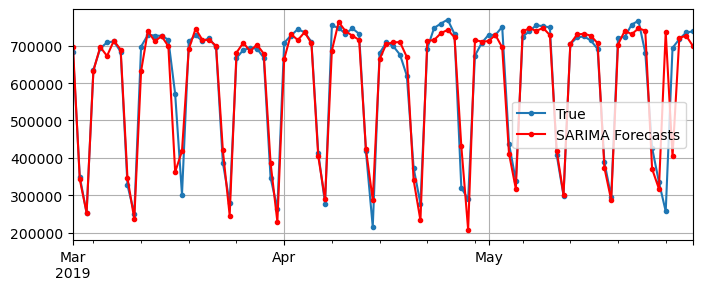

In [17]:
# 4) visualize SARIMA forecasts
fig5, ax5 = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax5, marker=".", grid=True)
ax5.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
ax5.legend();

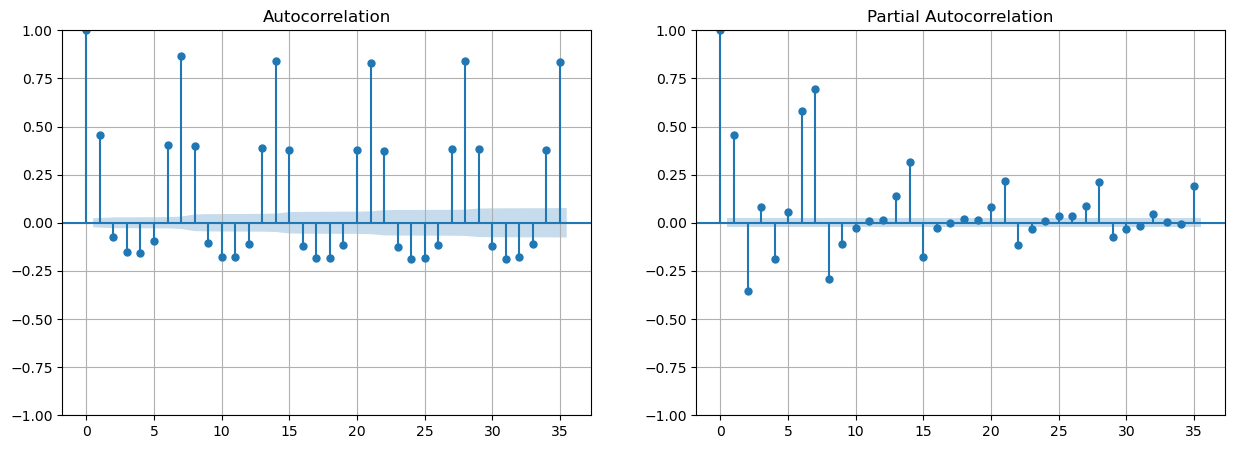

In [18]:
# 5) (optional topic) plot the Autocorrelation Function (ACF) and 
#         the Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig6, ax6 = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=ax6[0], lags=35)
ax6[0].grid()
plot_pacf(df[period]["rail"], ax=ax6[1], lags=35, method="ywm")
ax6[1].grid();

Prediction on time series with ML models
---
- naive forecasting and SARIMA provide two baselines
  - used to compare with ML models
- Let's try
  - a simple linear model
  - a simple RNN with just one recurrent neuron
  - a RNN with 32 recurrent neuron

In [19]:
# 0. utility functions 
# `tf.keras.utils.timeseries_​ data⁠set_from_array()`

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset) 

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [20]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


2024-03-24 14:45:28.003398: W tensorflow/core/framework/dataset.cc:959] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


In [21]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [22]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))
  
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))  

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

In [23]:
# 1.  forecast tomorrow’s ridership with `a basic linear model`
# based on the ridership of the past 8 weeks of data (56 days)
# The inputs to the model are sequences 
#   - usually a single sequence per day 
#   - each containing 56 values from time steps t – 55 to t.
# For each input sequence, the model will output a single value: 
# the forecast for time step t + 1.

# 1) split our data into 
# a training period, a validation period, and a test period
# and normalize to [0,1]
# which works nicely with the default weight initialization and learning rate

rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [24]:
# prepare the datasets with `tf.keras.utils.timeseries_dataset_from_array`
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [25]:
# 2) train `a basic linear model`
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500


33/33 [==============================] - 1s 5ms/step - loss: 0.4705 - mae: 0.8453 - val_loss: 0.0705 - val_mae: 0.3565
Epoch 2/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0252 - mae: 0.1768 - val_loss: 0.0084 - val_mae: 0.1052
Epoch 3/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0077 - mae: 0.0918 - val_loss: 0.0075 - val_mae: 0.0995
Epoch 4/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0067 - mae: 0.0854 - val_loss: 0.0044 - val_mae: 0.0695
Epoch 5/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0060 - mae: 0.0787 - val_loss: 0.0044 - val_mae: 0.0690
Epoch 6/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0059 - mae: 0.0808 - val_loss: 0.0041 - val_mae: 0.0644
Epoch 7/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0059 - mae: 0.0791 - val_loss: 0.0063 - val_mae: 0.0921
Epoch 8/500
33/33 [==============================] - 0s 2ms/step - loss: 0.0057 - mae: 0.0778 -

In [26]:
# 3) forecast with the `basic linear model`
# and compare with the two baselines
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6, sarima_mae, naive_mae['rail']

3/3 [==============================] - 0s 2ms/step - loss: 0.0022 - mae: 0.0377


(37731.25261068344, 32040.720089453378, 42143.27173913043)

In [27]:
# 2. forecast tomorrow’s ridership with a `simple RNN` 
# with just one recurrent neuron
# 1) create the model
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [28]:
# 2) defines a utility function we'll reuse several time
# train, find best parameters and evaluate a model

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
  early_stopping_cb = tf.keras.callbacks.EarlyStopping(
      monitor="val_mae", patience=50, restore_best_weights=True)
  opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
  model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
  history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                      callbacks=[early_stopping_cb])
  valid_loss, valid_mae = model.evaluate(valid_set)
  return valid_mae * 1e6

In [29]:
# 3) train and evaluate the model
# compare with (sarima_mae, naive_mae['rail']) = (32040.720089453378, 42143.27173913043)
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 1s 11ms/step - loss: 0.0312 - mae: 0.2089 - val_loss: 0.0118 - val_mae: 0.1152
Epoch 2/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0117 - mae: 0.1191 - val_loss: 0.0119 - val_mae: 0.1142
Epoch 3/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0115 - mae: 0.1201 - val_loss: 0.0116 - val_mae: 0.1146
Epoch 4/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0114 - mae: 0.1204 - val_loss: 0.0115 - val_mae: 0.1143
Epoch 5/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0113 - mae: 0.1204 - val_loss: 0.0114 - val_mae: 0.1140
Epoch 6/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0113 - mae: 0.1201 - val_loss: 0.0114 - val_mae: 0.1136
Epoch 7/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0112 - mae: 0.1198 - val_loss: 0.0113 - val_mae: 0.1134
Epoch 8/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0111 - 

102857.50031471252

In [30]:
# 3. forecast tomorrow’s ridership with a `RNN` 
# with 32 recurrent neurons
# 1) create the model
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [31]:
# 2) train and evaluate the model
# compare with (sarima_mae, naive_mae['rail']) = (32040.720089453378, 42143.27173913043)

fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 1s 12ms/step - loss: 0.0277 - mae: 0.1799 - val_loss: 0.0096 - val_mae: 0.1176
Epoch 2/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0073 - mae: 0.0956 - val_loss: 0.0052 - val_mae: 0.0789
Epoch 3/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0056 - mae: 0.0810 - val_loss: 0.0039 - val_mae: 0.0713
Epoch 4/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0048 - mae: 0.0739 - val_loss: 0.0034 - val_mae: 0.0657
Epoch 5/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0041 - mae: 0.0663 - val_loss: 0.0033 - val_mae: 0.0633
Epoch 6/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0040 - mae: 0.0639 - val_loss: 0.0027 - val_mae: 0.0543
Epoch 7/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0036 - mae: 0.0589 - val_loss: 0.0033 - val_mae: 0.0575
Epoch 8/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0034 - 

29919.011518359184

In [32]:
# 4. forecast tomorrow’s ridership with a `deep RNN` 
# with 3 recurrent layers, each contains  32 recurrent neurons
# 1) create the model
# The first two are sequence-to-sequence layers, 
#   and the last one is a sequence-to-vector layer
#   Make sure to set return_sequences=True for all recurrent layers
#       to output  Ŷ(0) to  Ŷ(t)   
#       except the last one so it will output only Ŷ(t)
# Finally, the Dense layer produces the model’s forecast
#   think of it as a vector(Ŷ(t)) -to-vector (forecast) layer
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [33]:
# 2) train and evaluate the model
# compare with (sarima_mae, naive_mae['rail']) = (32040.720089453378, 42143.27173913043)

fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 3s 27ms/step - loss: 0.0335 - mae: 0.1967 - val_loss: 0.0202 - val_mae: 0.1963
Epoch 2/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0181 - mae: 0.1616 - val_loss: 0.0175 - val_mae: 0.1263
Epoch 3/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0166 - mae: 0.1568 - val_loss: 0.0183 - val_mae: 0.1202
Epoch 4/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0166 - mae: 0.1549 - val_loss: 0.0150 - val_mae: 0.1363
Epoch 5/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0169 - mae: 0.1571 - val_loss: 0.0141 - val_mae: 0.1379
Epoch 6/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0149 - mae: 0.1490 - val_loss: 0.0134 - val_mae: 0.1223
Epoch 7/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0139 - mae: 0.1425 - val_loss: 0.0104 - val_mae: 0.1097
Epoch 8/500
33/33 [==============================] - 1s 16ms/step - loss: 0.

29719.192534685135

Forecasting Multivariate Time Series
---
Neural networks can deal with 
- multivariate time series 
  - almost without change to their architecture
- as well as multiple related tasks

In [34]:
# 1. forecast the rail time series 
#     using both the bus data, rail data, and the day type as input

# 1) prepare the input
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar, dtype=int)  # one-hot encode the day type

In [35]:
df_mulvar.iloc[:,2:].head()

,next_day_type_A,next_day_type_U,next_day_type_W
date,,,
2001-01-01,0,0,1
2001-01-02,0,0,1
2001-01-03,0,0,1
2001-01-04,0,0,1
2001-01-05,1,0,0


In [36]:
# 2) split the dataset
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [37]:
# 3) preprocess the dataset
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [38]:
# 4) build the model
# the input_shape now receives 5 inputs instead of 1
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

In [39]:
# 5) compiles, fits, and evaluates the model, like earlier
# compare with (sarima_mae, naive_mae['rail']) = (32040.720089453378, 42143.27173913043)

fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500


33/33 [==============================] - 1s 12ms/step - loss: 0.0604 - mae: 0.2438 - val_loss: 0.0021 - val_mae: 0.0542
Epoch 2/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0035 - mae: 0.0639 - val_loss: 0.0014 - val_mae: 0.0404
Epoch 3/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0020 - mae: 0.0457 - val_loss: 0.0012 - val_mae: 0.0391
Epoch 4/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0018 - mae: 0.0431 - val_loss: 0.0027 - val_mae: 0.0654
Epoch 5/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0017 - mae: 0.0421 - val_loss: 8.1061e-04 - val_mae: 0.0295
Epoch 6/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0015 - mae: 0.0394 - val_loss: 0.0012 - val_mae: 0.0402
Epoch 7/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0016 - mae: 0.0411 - val_loss: 0.0012 - val_mae: 0.0406
Epoch 8/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0014 - mae: 0.0

23976.27755999565

In [40]:
# 2. make the RNN forecast both the bus and rail ridership
# change the targets to be ["bus", "rail"] and add one more output neuron
# the output mae = 0.5*bus mae + 0.5*rail mae
seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2) # two outputs 
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 1s 12ms/step - loss: 0.0382 - mae: 0.1881 - val_loss: 0.0025 - val_mae: 0.0577
Epoch 2/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0032 - mae: 0.0568 - val_loss: 0.0012 - val_mae: 0.0335
Epoch 3/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0023 - mae: 0.0466 - val_loss: 9.4493e-04 - val_mae: 0.0307
Epoch 4/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0021 - mae: 0.0452 - val_loss: 8.8401e-04 - val_mae: 0.0294
Epoch 5/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0020 - mae: 0.0450 - val_loss: 8.5476e-04 - val_mae: 0.0299
Epoch 6/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0019 - mae: 0.0435 - val_loss: 0.0011 - val_mae: 0.0336
Epoch 7/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0018 - mae: 0.0423 - val_loss: 8.8879e-04 - val_mae: 0.0299
Epoch 8/500
33/33 [==============================] - 0s 6ms/step -

25061.93146109581

In [41]:
# 2) evaluates the naive forecasts for bus
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

43441.63157894738

In [42]:
# 3) evaluates the multitask RNN's forecasts both bus and rail
# the results are very good
Y_preds_valid = multask_model.predict(valid_multask_ds)
weighted_sum = 0.
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.mean_absolute_error(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    weighted_sum += mae
    print(name, float(mae))
print(f"weighted mae {float(weighted_sum)/2}")

3/3 [==============================] - 0s 4ms/step
bus 25645.400390625
rail 24478.462890625
weighted mae 25061.931640625


Forecasting Several Time Steps Ahead
---
two options
- ① use the univar_model RNN to make predictions recursively
  - predict the next value
  - add that value to the inputs as if the predicted value had actually occurred
  - then use the model again to predict the following value, and so on
  - ⚠️ an error at one time step impacts all following steps
    - so it’s preferable to use this technique only for a `small number of steps`
- ② train an RNN to predict the next multiple values in one shot
  - use a `sequence-to-vector RNN` that will output multiple values instead of 1
    - it forecasts only at the very last time step
  - use a `sequence-to-sequence RNN` to forecast at each and every time step
    - its loss will contain a term for the output of the RNN at each and every time step
      - not just for the output at the last time step as sequence-to-vector RNN
    - This will both stabilize and speed up training
time step
- doesn’t accumulate errors like option ①

In [43]:
# 1. option ①
# 1) use the univar_model to predict all 14 next values one by one
# recurrent layers expect 3D inputs [batch, timesteps, feature]
X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    # append the new value along the time axis (axis=1) 
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 15ms/step


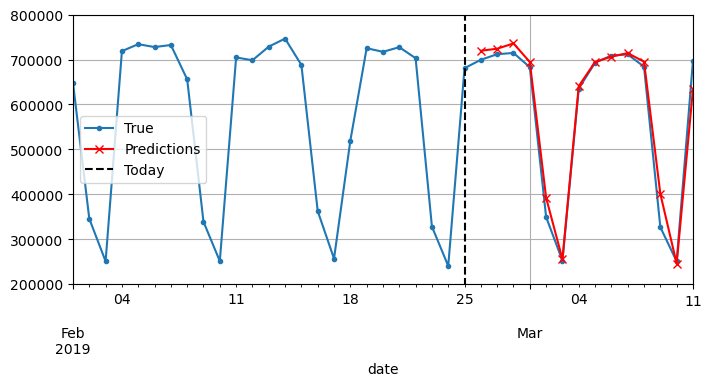

In [44]:
# 2) The forecasts start on 2019-02-26, as it is the 57th day of 2019, 
# and they end  on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig7, ax7 = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax7)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax7)
ax7.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax7.set_ylim([200_000, 800_000])
ax7.legend(loc="center left");

In [45]:
# 2. option ②
# use a `sequence-to-vector RNN`
# 1) prepare the datasets
# change the targets to be vectors containing the next 14 values
# create datasets without targets (targets=None) 
#   and with longer sequences, of length seq_length + 14
# then split them into inputs and targets
def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [46]:
# 2) create an RNN that predicts all 14 next values at once
ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14) # 14 neurons for 14 outputs
])

In [47]:
# 3) compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/500


33/33 [==============================] - 1s 12ms/step - loss: 0.0891 - mae: 0.2991 - val_loss: 0.0239 - val_mae: 0.1615
Epoch 2/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0157 - mae: 0.1380 - val_loss: 0.0115 - val_mae: 0.1161
Epoch 3/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0115 - mae: 0.1181 - val_loss: 0.0093 - val_mae: 0.1037
Epoch 4/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0101 - mae: 0.1097 - val_loss: 0.0081 - val_mae: 0.0964
Epoch 5/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0091 - mae: 0.1031 - val_loss: 0.0070 - val_mae: 0.0894
Epoch 6/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0084 - mae: 0.0971 - val_loss: 0.0065 - val_mae: 0.0866
Epoch 7/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0079 - mae: 0.0931 - val_loss: 0.0057 - val_mae: 0.0808
Epoch 8/500
33/33 [==============================] - 0s 6ms/step - loss: 0.0074 - mae: 0.0891 

33342.94259548187

In [48]:
# 4) predict the next 14 values at once
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

1/1 [==============================] - 0s 155ms/step


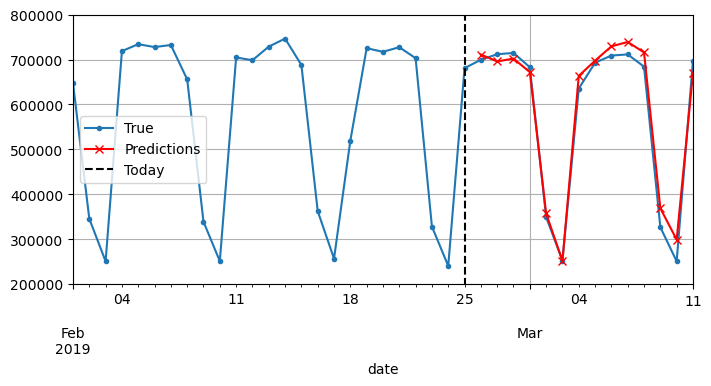

In [49]:
# 5) visualize the predictions
Y_pred = pd.Series(Y_pred[0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig8, ax8 = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax8)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax8)
ax8.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax8.set_ylim([200_000, 800_000])
ax8.legend(loc="center left");

In [50]:
# 3. option ②
# use a `sequence-to-sequence RNN`
# the targets are sequences of consecutive window of the same length as the inputs, 
# shifted by one time step at each time step
# ex. for the ride forecasting problem above,
# the model will output a vector containing the forecasts 
# for time steps 1 to 14 at time step 0 
# steps 2 to 15 at time step 1, and so on,
# steps 56 to 69 at the last time step 55.

# 1) prepare the dataset: each instance has a
# window as input and a sequence of windows as output 
# ex. turn the series of numbers 0 to 6 into a dataset
# containing sequences of 4 consecutive windows, each of length 3
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

In [51]:
# split these elements into the desired inputs and targets:
# ex.  
# the first input sequence is [0, 1, 2, 3] with
# corresponding targets: [[1, 2], [2, 3], [3, 4], [4, 5]]
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset) 

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

In [52]:
# wrap this idea into a utility function. 
# It will also take care of shuffling (optional) and batching:

def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [53]:
# finally prepare the datasets
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [54]:
# 2) build the model
# `return_sequences=True` make the RNN output a sequence of vectors
#   each of size 32
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

In [55]:
# 3) train and evaluate the model
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500


33/33 [==============================] - 1s 18ms/step - loss: 0.0752 - mae: 0.2825 - val_loss: 0.0174 - val_mae: 0.1405
Epoch 2/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0102 - mae: 0.1073 - val_loss: 0.0085 - val_mae: 0.0947
Epoch 3/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0067 - mae: 0.0825 - val_loss: 0.0064 - val_mae: 0.0778
Epoch 4/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0057 - mae: 0.0728 - val_loss: 0.0058 - val_mae: 0.0733
Epoch 5/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0051 - mae: 0.0672 - val_loss: 0.0053 - val_mae: 0.0686
Epoch 6/500
33/33 [==============================] - 0s 7ms/step - loss: 0.0048 - mae: 0.0644 - val_loss: 0.0050 - val_mae: 0.0656
Epoch 7/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0046 - mae: 0.0626 - val_loss: 0.0047 - val_mae: 0.0630
Epoch 8/500
33/33 [==============================] - 0s 8ms/step - loss: 0.0045 - mae: 0.0614 

47046.75078392029

In [56]:
# 4) forecast the rail ridership for the next 14 days
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output

1/1 [==============================] - 0s 176ms/step


In [57]:
# 5) evaluate the model's performance from step t+1 to t+14
#  the performance continues to drop gradually as the model 
#  tries to forecast further into the future
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

3/3 [==============================] - 0s 10ms/step
MAE for +1: 22,807
MAE for +2: 29,703
MAE for +3: 32,034
MAE for +4: 33,976
MAE for +5: 33,366
MAE for +6: 33,097
MAE for +7: 33,849
MAE for +8: 36,079
MAE for +9: 33,495
MAE for +10: 31,910
MAE for +11: 36,382
MAE for +12: 38,089
MAE for +13: 36,758
MAE for +14: 35,731


Handling Long Sequences with Deep RNNs
---
- Simple RNNs do not perform well on long time series
  - can be handled with deep RNNs
- training deep RNNs has two common problems
  - the unstable gradients problem
  - the Short-Term Memory Problem
    - when an RNN processes a long sequence, 
    - it will gradually forget the first inputs in the sequence.

Fighting the Unstable Gradients Problem
---
- Many of the tricks used in alleviating deep nets' unstable gradients problem can also be used for RNNs: 
  - good parameter initialization, faster optimizers, dropout, and so on.
- However, nonsaturating activation functions (e.g., ReLU) may 
  - actually render the RNN even more unstable during training
  - since they will increase the outputs more and more at each time step
    - until the outputs explode
    - if they increase the outputs slightly at the first time step
  - this risk can be reduced using a smaller learning rate, or a saturating activation function
    - or gradient clipping
- Moreover, batch normalization cannot be used as efficiently with RNNs as with DNNs
  - adding a BatchNormalization layer before each recurrent layer will slow down training
  - and may not help much
- `Layer normalization` is very similar to BN but often works better with RNNs
  - by normalizing across the features dimension instead of across the batch dimension
    - typically used right after the linear combination of the inputs and the hidden states
  - learns a `scale` and an `offset` parameter for each input like BN
  - can compute the required statistics on the fly 
    - at each time step, independently for each instance
    - i.e. as opposed to BN, it behaves the same way during training and testing
    - no need to use exponential moving averages to estimate the feature statistics across all instances in the training set
- `Dropout` can be applied between each time step through a custom cell
  - most recurrent layers and cells provided by Keras have hyperparameters
    - `dropout`, the dropout rate for the inputs
    - `recurrent_dropout`,  the dropout rate for the hidden states
  - ∴ no need to create a custom cell to apply dropout 

In [58]:
# 1.  implements a custom memory cell
# will behave like a SimpleRNNCell
# also apply layer normalization at each time step
# 1) define the model
class LNSimpleRNNCell(tf.keras.layers.Layer):
  def __init__(self, units, activation="tanh", **kwargs):
    super().__init__(**kwargs)
    self.state_size = units
    self.output_size = units
    self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                         activation=None)
    # `activation=None` no activation function because the layer normalization
    # is applied after the linear operation but before the activation function
    self.layer_norm = tf.keras.layers.LayerNormalization()
    self.activation = tf.keras.activations.get(activation)

  def call(self, inputs, states):
    #  in a SimpleRNNCell, new_states[0] == outputs
    outputs, new_states = self.simple_rnn_cell(inputs, states)
    norm_outputs = self.activation(self.layer_norm(outputs))
    return norm_outputs, [norm_outputs] # = (outputs, new hidden states)

In [59]:
# 2) create the model
custom_ln_model = tf.keras.Sequential([
  tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                      input_shape=[None, 5]),
  tf.keras.layers.Dense(14)
])

In [60]:
custom_ln_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rnn (RNN)                   (None, None, 32)          1280      
                                                                 
 dense_7 (Dense)             (None, None, 14)          462       
                                                                 
Total params: 1742 (6.80 KB)
Trainable params: 1742 (6.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
# 3) Just training for 10 epochs to show that it works
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=10)

Epoch 1/10
33/33 [==============================] - 2s 22ms/step - loss: 0.0819 - mae: 0.2844 - val_loss: 0.0202 - val_mae: 0.1402
Epoch 2/10
33/33 [==============================] - 0s 12ms/step - loss: 0.0132 - mae: 0.1292 - val_loss: 0.0134 - val_mae: 0.1130
Epoch 3/10
33/33 [==============================] - 0s 13ms/step - loss: 0.0103 - mae: 0.1113 - val_loss: 0.0116 - val_mae: 0.1064
Epoch 4/10
33/33 [==============================] - 0s 13ms/step - loss: 0.0092 - mae: 0.1035 - val_loss: 0.0103 - val_mae: 0.1011
Epoch 5/10
33/33 [==============================] - 0s 12ms/step - loss: 0.0086 - mae: 0.0985 - val_loss: 0.0094 - val_mae: 0.0964
Epoch 6/10
33/33 [==============================] - 0s 12ms/step - loss: 0.0081 - mae: 0.0944 - val_loss: 0.0092 - val_mae: 0.0954
Epoch 7/10
33/33 [==============================] - 0s 13ms/step - loss: 0.0076 - mae: 0.0910 - val_loss: 0.0087 - val_mae: 0.0929
Epoch 8/10
33/33 [==============================] - 0s 13ms/step - loss: 0.0073 - m

81284.56026315689

Tackling the Short-Term Memory Problem
---
- by various types of cells with long-term memory such as
  - the `long short-term memory (LSTM)` cell
  - the `gated recurrent unit (GRU)` cell
- They are so successful that the basic cells are not used much anymore
- RNNs with LSTM and GRU cells can tackle much longer sequences than simple RNNs, but they still have 
  - a fairly limited short-term memory
  - a hard time learning long-term patterns in sequences of 100 time steps or more
    - such as audio samples, long time series, or long sentences
  - solved by shortening the input sequences using 1D convolutional layers

LSTM cells
---
- can be used very much like a basic cell, except
  - perform much better
  - training will converge faster
  - able to detect longer-term patterns in the data
  - implemented as `tf.keras.layers.LSTMCell`
- its architecture also looks exactly like a regular cell (p7), except that its state is split into two vectors:
  - ${ \mathbf{h}_{(t)} }$ is the `short-term state` (`h` stands for `hidden`)
  - ${ \mathbf{c}_{(t)} }$ is the `long-term state` (`c` stands for `cell`)
  - key idea of the network:
    - can learn what to store in the long-term state
    - what to throw away
    - and what to read from it
- LSTM computations for a single instance
  - ${ \mathbf{i}_{(t)} = σ(\mathbf{W}_{xi}^⊺ \mathbf{x}_{(t)} + \mathbf{W}_{hi}^⊺ \mathbf{h}_{(t−1)} +  \mathbf{b}_i ) }$
    - the input gate which parts of ${ \mathbf{g}_{(t)} }$ should be added to the long-term state ${ \mathbf{c}_{(t)} }$
  - ${ \mathbf{f}_{(t)} = σ(\mathbf{W}_{xf}^⊺ \mathbf{x}_{(t)} + \mathbf{W}_{hf}^⊺ \mathbf{h}_{(t−1)} +  \mathbf{b}_f ) }$
    - the forget gate controls which parts of the long-term state ${ \mathbf{c}_{(t-1)} }$ should be erased
  - ${ \mathbf{o}_{(t)} = σ(\mathbf{W}_{xo}^⊺ \mathbf{x}_{(t)} + \mathbf{W}_{ho}^⊺ \mathbf{h}_{(t−1)} +  \mathbf{b}_o ) }$
    - the output gate controls which parts of the long-term state ${ \mathbf{c}_{(t)} }$ should be read and output at this time step, both to ${ \mathbf{h}_{(t)} }$ and to ${ \mathbf{y}_{(t)} }$
  - ${ \mathbf{g}_{(t)} = \tanh (\mathbf{W}_{xg}^⊺ \mathbf{x}_{(t)} + \mathbf{W}_{hg}^⊺ \mathbf{h}_{(t−1)} + \mathbf{b}_g ) }$
    - the main layer keeps the most important inputs and drops the rest
  - The three `gate controllers` control how much to open the gates by feeding the `logistic` activation function output values to the element-wise multiplication operations ⊗: 
    - if they output 0s they close the gates
    - if they output 1s they open the gates
    - `0 < outputs < 1` partly open the gates
  - ${ \mathbf{c}_{(t)} = \mathbf{f}_{(t)} ⊗ \mathbf{c}_{(t−1)} + \mathbf{i}_{(t)} ⊗ \mathbf{g}_{(t)} }$
  - ${ \mathbf{y}_{(t)} = \mathbf{h}_{(t)} = \mathbf{o}_{(t)}⊗ \tanh (\mathbf{c}_{(t)} ) }$
- ${ \mathbf{b}_f}$ is initialized to a vector full of 1s instead of 0s
  - This prevents forgetting everything at the beginning of training

In [62]:
# 1. create a RNN with LSTM layer
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [63]:
# 2) training for 5 epochs to show that it works
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 3s 29ms/step - loss: 0.0600 - mae: 0.2601 - val_loss: 0.0186 - val_mae: 0.1697
Epoch 2/5
33/33 [==============================] - 0s 11ms/step - loss: 0.0173 - mae: 0.1575 - val_loss: 0.0171 - val_mae: 0.1458
Epoch 3/5
33/33 [==============================] - 0s 11ms/step - loss: 0.0157 - mae: 0.1510 - val_loss: 0.0166 - val_mae: 0.1403
Epoch 4/5
33/33 [==============================] - 0s 12ms/step - loss: 0.0150 - mae: 0.1466 - val_loss: 0.0158 - val_mae: 0.1370
Epoch 5/5
3/3 [==============================] - 0s 13ms/step - loss: 0.0152 - mae: 0.1335


133510.5299949646

GRU cells
---
- (p8) a variant of the LSTM cell with these simplifications
  - implemented as `tf.keras.layers.GRUCell`
  - Both state vectors are merged into a single vector ${ \mathbf{h}_{(t)} }$
  - A `single gate controller` ${ \mathbf{z}_{(t)} }$ controls both the `forget` gate and the `input` gate
    - the sum of the openness of both gates equals to 1
    - i.e. whenever a memory must be stored, the store location is erased first
  - There is `no output gate`
    - the full state vector ${ \mathbf{h}_{(t)} }$ is output at every time step
  - There is a `new gate controller` ${ \mathbf{r}_{(t)} }$ 
    - controls which part of the previous state will be merged to the main layer ${ \mathbf{g}_{(t)} }$
- GRU computations for a single instance
  - ${ \mathbf{z}_{(t)} = σ(\mathbf{W}_{xz}^⊺ \mathbf{x}_{(t)} + \mathbf{W}_{hz}^⊺ \mathbf{h}_{(t−1)} +  \mathbf{b}_z ) }$
  - ${ \mathbf{r}_{(t)} = σ(\mathbf{W}_{xr}^⊺ \mathbf{x}_{(t)} + \mathbf{W}_{hr}^⊺ \mathbf{h}_{(t−1)} +  \mathbf{b}_r ) }$
  - ${ \mathbf{g}_{(t)} = \tanh \left(\mathbf{W}_{xg}^⊺ \mathbf{x}_{(t)} + \mathbf{W}_{hg}^⊺ (\mathbf{r}_{(t)} ⊗ \mathbf{h}_{(t−1)}) + \mathbf{b}_g \right) }$
  - ${ \mathbf{h}_{(t)} = \mathbf{z}_{(t)}⊗ \mathbf{h}_{(t-1)} + (1-\mathbf{z}_{(t)})⊗ \mathbf{g}_{(t)}}$


In [64]:
# 1. create a RNN with GRU layer
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [65]:
# 2) training for 5 epochs to show that it works
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 3s 26ms/step - loss: 0.0598 - mae: 0.2640 - val_loss: 0.0176 - val_mae: 0.1577
Epoch 2/5
33/33 [==============================] - 0s 12ms/step - loss: 0.0143 - mae: 0.1392 - val_loss: 0.0133 - val_mae: 0.1280
Epoch 3/5
33/33 [==============================] - 0s 13ms/step - loss: 0.0115 - mae: 0.1244 - val_loss: 0.0120 - val_mae: 0.1176
Epoch 4/5
33/33 [==============================] - 0s 12ms/step - loss: 0.0104 - mae: 0.1156 - val_loss: 0.0111 - val_mae: 0.1124
Epoch 5/5
3/3 [==============================] - 0s 12ms/step - loss: 0.0106 - mae: 0.1099


109880.98382949829

Using 1D convolutional layers to process sequences
---
- a 1D convolutional layer slides several kernels across a sequence
  - producing a 1D feature map per kernel
  - Each kernel will learn to detect a single very short sequential pattern
    - no longer than the kernel size
- With ℕ kernels, the layer’s output will be composed of ℕ 1D sequences
  - equivalent to a single ℕD sequences
  - this means a neural network can mix recurrent layers and 1D convolutional layers
    - or even 1D pooling layers
- ex. a 1D convolutional layer with a stride of 1 and "same" padding produces
  - a output sequence with the same length as the input sequence
  - "valid" padding or a stride greater than 1 produces output sequence shorter than the input sequence

In [66]:
# 1. build a convolutional RNN
# a) the 1D convolutional layer that downsamples the input sequence 
#     by a factor of 2, using a stride of 2. The kernel size is larger
#     than the stride, so all inputs will be used to compute the layer’s
#     output, and therefore the model can learn to preserve the useful
#     information, dropping only the unimportant details
# b) By shortening the sequences the convolutional layer may help 
#     the GRU layers detect longer patterns, so we can afford to double 
#     the input sequence length to 112 days
# c)  Note that we must also crop off the first three time steps 
#     in the targets: indeed, the kernel’s size is 4, so the first output 
#     of the convolutional layer will be based on the input time steps 0 to 3, 
#     and the first forecasts will be for time steps 4 to 17 
#     (instead of time steps 1 to 14). Moreover, we must downsample the targets 
#     by a factor of 2, because of the stride:

conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

In [67]:
# 2) training for 5 epochs to show that it works
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 3s 43ms/step - loss: 0.0608 - mae: 0.2649 - val_loss: 0.0215 - val_mae: 0.1591
Epoch 2/5
31/31 [==============================] - 0s 12ms/step - loss: 0.0170 - mae: 0.1574 - val_loss: 0.0180 - val_mae: 0.1447
Epoch 3/5
31/31 [==============================] - 0s 12ms/step - loss: 0.0151 - mae: 0.1496 - val_loss: 0.0168 - val_mae: 0.1386
Epoch 4/5
31/31 [==============================] - 0s 12ms/step - loss: 0.0139 - mae: 0.1427 - val_loss: 0.0156 - val_mae: 0.1312
Epoch 5/5
1/1 [==============================] - 0s 59ms/step - loss: 0.0138 - mae: 0.1249


124872.17783927917

[WaveNet](https://homl.info/wavenet)
---
- (p9) a `stack of 1D convolutional layers` with dilation rate `double` at each layer
  - the `first` convolutional layer gets a glimpse of just `2 time steps` at a time
  - the next layer sees `4 time steps`
    - i.e. its receptive field is four time steps long
  - the next next sees `8 time steps`, and so on
  - the `lower` layers learn `short-term patterns` 
    - while the `higher` layers learn `long-term patterns`
- can process `extremely large sequences` very efficiently with the `doubling dilation rate`
- acts like a super-efficient convolutional layer with multiple kernels of sizes 
  - in the geometric sequence with common ratio of 2: (2, 4, 8, ⋯, ${ 2^ℓ }$)
  - ℓ is the total number of the stacked 1D convolutional layers

In [68]:
# 1. create a simple WaveNet
# "causal" padding is like "same" padding 
#   except that the zeros are prepended only at the start of the input sequence, 
#   instead of both sides

wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

In [69]:
# 2) training for 5 epochs to show that it works
fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 3s 34ms/step - loss: 0.0751 - mae: 0.3073 - val_loss: 0.0240 - val_mae: 0.1678
Epoch 2/5
31/31 [==============================] - 0s 12ms/step - loss: 0.0173 - mae: 0.1584 - val_loss: 0.0184 - val_mae: 0.1569
Epoch 3/5
31/31 [==============================] - 0s 11ms/step - loss: 0.0163 - mae: 0.1581 - val_loss: 0.0187 - val_mae: 0.1539
Epoch 4/5
31/31 [==============================] - 0s 11ms/step - loss: 0.0161 - mae: 0.1573 - val_loss: 0.0186 - val_mae: 0.1538
Epoch 5/5
1/1 [==============================] - 0s 57ms/step - loss: 0.0184 - mae: 0.1541


154130.57804107666